In [1]:
import gym
gym.logger.set_level(40)
import envs
import autograd.numpy as np
from autograd import grad, jacobian
import matplotlib.pyplot as plt
from controller import MPC
from stable_koopman2 import StableKoopman2
import argparse
import random

In [2]:
env_name = "CartPoleContinuous-v0"
env = gym.make(env_name)
train_epi = 50
max_step = 500

In [3]:
def basis(state, action):
    action = action[0]
    extra_basis = np.array([np.sin(state[2]), action*np.cos(state[2])])
    action_basis = np.array([action])
    psi = np.hstack((state, extra_basis, action_basis))
    return psi

print(basis(np.zeros(4), [0]))

[0. 0. 0. 0. 0. 0. 0.]


In [4]:
num_state = env.observation_space.shape[0]
num_basis = num_state + 3
SK = StableKoopman2()

In [5]:
X = []
Y = []
U = []

for i in range(train_epi):
    state = env.reset(np.array([0.0,0.0,0.0,0.0]))
    step = 0
    
    while step < max_step:
        action = env.action_space.sample()
        new_state, _, _, _ = env.step(action)

        X.append(basis(state, action))
        Y.append(basis(new_state, action))
        U.append(action)


        state = new_state
        step += 1

X = np.array(X).transpose()
Y = np.array(Y).transpose()

print("X shape:",X.shape)
print("Y shape:",Y.shape)

X shape: (7, 25000)
Y shape: (7, 25000)


In [8]:
params = { 
    'log_memory' : 'store_true',
    'conjugate_gradient': 'store_true',
    'step_size_factor': 5,
    'fgm_max_iter': 20,
    'alpha' : 0.5,
    'stability_relaxation': 0.,
    'time_limit' : 1800,
    'eps' : 1e-12
}

K,mem = SK.learn_stable_soc(X=X, Y=Y, **params)
print(K)

K_h_T = K[:num_state, :]


[[ 9.98376457e-01  1.99675291e-02  6.23142088e-13 -7.08123596e-12
  -1.60507815e-11  3.47469730e-10 -2.99661680e-10]
 [-2.51532477e-12  9.98376457e-01 -2.10492135e-12  3.72591634e-11
   8.46400554e-11 -1.80200235e-09  1.99675292e+00]
 [ 5.67880125e-13 -9.09126534e-12  9.98376457e-01  1.99675291e-02
  -2.42256512e-11  5.10614023e-10 -1.93882963e-10]
 [-3.79691515e-11  4.57038694e-10 -6.91329959e-11  9.98376457e-01
   1.77892532e-01 -1.81522992e+00  5.70934388e-07]
 [ 3.72915944e-05 -2.19275997e-04  2.52300674e-04 -1.33224631e-03
   9.64162235e-01 -1.02609891e-03 -3.80069554e-03]
 [ 1.49377130e-05 -8.84123664e-05  2.91292484e-05 -1.14323316e-04
   2.00862258e-03  9.62524865e-01 -1.19729616e-03]
 [-1.00733426e-12  1.33204246e-11 -6.84352392e-13  1.74697875e-11
   3.97320710e-11 -8.38189693e-10  9.98376455e-01]]


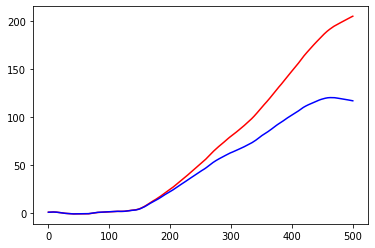

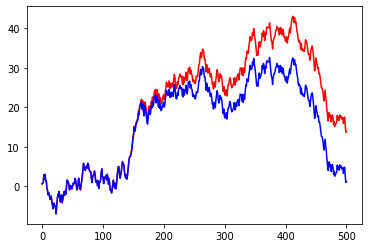

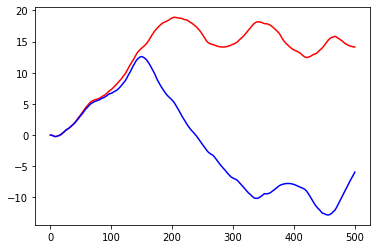

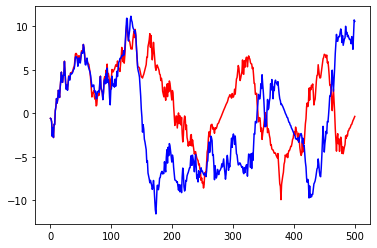

In [7]:
state = env.reset(np.array([1.0,0.0,0.0,0.0]))
predict_state = state.copy()
step = 0
predict_arr = []
actual_arr = []


freq = 50
while step < max_step:
    action = env.action_space.sample()

    #propagate actual state
    new_state, _, _, _ = env.step(action)
    actual_arr.append(new_state)

    if step % freq == 0:
        predict_state = state

    #propagate predicted state
    new_predict_state = (K_h_T @ basis(predict_state, action).reshape(-1,1)).flatten()
    predict_arr.append(new_predict_state)

    #update
    state = new_state
    predict_state = new_predict_state
    step += 1
    
    
actual_arr = np.array(actual_arr)
predict_arr = np.array(predict_arr)

for s in range(4):
    plt.plot(np.linspace(0,max_step, max_step), actual_arr[:,s], color='red')
    plt.plot(np.linspace(0,max_step, max_step), predict_arr[:,s], color='blue')

    plt.show()

end


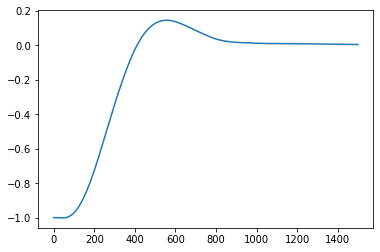

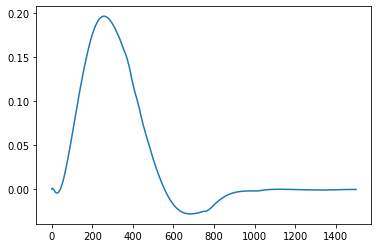

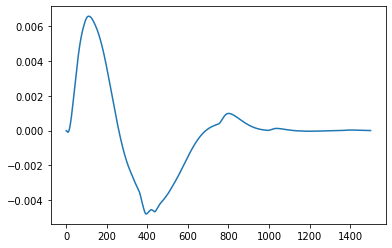

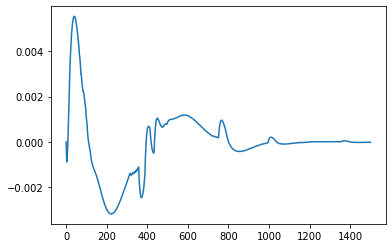

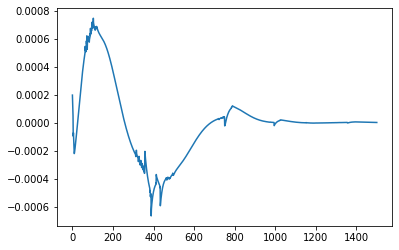

In [14]:
controller = MPC(50, K_h_T, basis, env.dt)
state = env.reset(np.array([-1.0,0.0,0.0,0.0]))
action = np.array([0.0])
max_step = 1500

step = 0
traj_arr = []
action_arr = []

while step < max_step:

    traj_arr.append(state)
    action = controller(state, 0.001, 5, 1.0)#controller(state)#controller(state, 1.0)
    action_arr.append(action)
    new_state, _, _, _ = env.step(action)
    

    state = new_state
    step += 1
    
print('end')

traj_arr = np.array(traj_arr)
action_arr = np.array(action_arr)

t_step = np.linspace(0,max_step,max_step)
for s in range(4):
    plt.plot(t_step, traj_arr[:,s])
    plt.show()

plt.plot(t_step, action_arr)
plt.show()